## CRISP-DM (https://www.datascience-pm.com/crisp-dm-2/)

- 1. Business Understanding
- 2. Data Understanding
- 3. Data Preparation
- 4. Modeling
- 5. Evaluation
- 6. Deployment

### 1. Business Understanding - Jonnas

- 1.1. Determine business objectives
- 1.2. Assess situation
- 1.3. Determine data mining goals
- 1.4. Produce project plan

Isto deve ser so teorico

### 2. Data Understanding - Vicente

- 2.1. Collect initial data - ler os dados todos
- 2.2. Describe data - examinar os dados e descreve-los, as suas propriedades, numero de ocorrencia, etc.
- 2.3. Explore data - explorar os dados, visualizalos, ver padroes, etc.
- 2.4. Verify data quality - verificar a integridade dos dados, ver se tem erros, inconsistencias, etc.

Tipos de respostas para a categoria General_Health:
['Excellent' 'Fair' 'Good' 'Poor' 'Very Good']

Tipos de respostas para a categoria Checkup:
['5 or more years ago' 'Never' 'Within the past 2 years'
 'Within the past 5 years' 'Within the past year']

Tipos de respostas para a categoria Exercise:
['No' 'Yes']

Tipos de respostas para a categoria Heart_Disease:
['No' 'Yes']

Tipos de respostas para a categoria Skin_Cancer:
['No' 'Yes']

Tipos de respostas para a categoria Other_Cancer:
['No' 'Yes']

Tipos de respostas para a categoria Depression:
['No' 'Yes']

Tipos de respostas para a categoria Diabetes:
['No' 'No, pre-diabetes or borderline diabetes' 'Yes'
 'Yes, but female told only during pregnancy']

Tipos de respostas para a categoria Arthritis:
['No' 'Yes']

Tipos de respostas para a categoria Sex:
['Female' 'Male']

Tipos de respostas para a categoria Age_Category:
['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59' '60-64'
 '65-69' '70-74' '75-79' '80+']

Tipos d

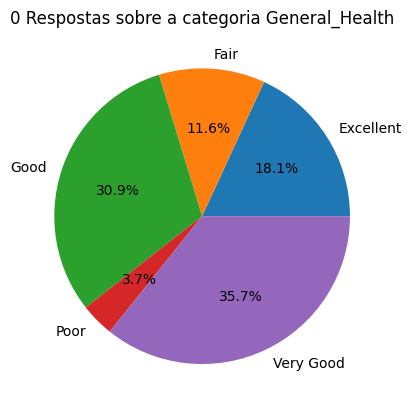

['5 or more years ago' 'Never' 'Within the past 2 years'
 'Within the past 5 years' 'Within the past year']
[13421, 1407, 37213, 17442, 239371]


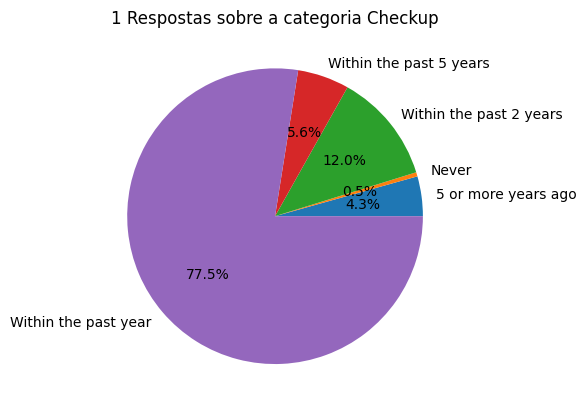

['No' 'Yes']
[69473, 239381]


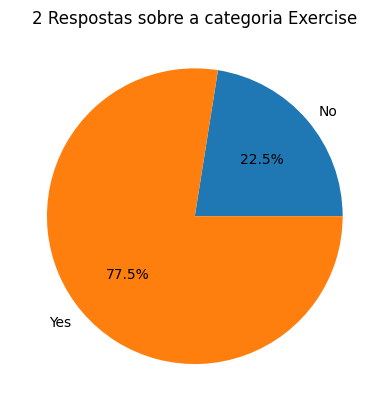

['No' 'Yes']
[283883, 24971]


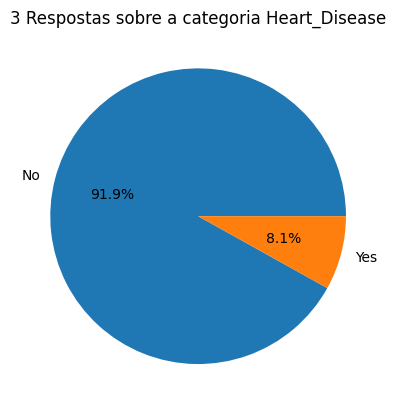

['No' 'Yes']
[278860, 29994]


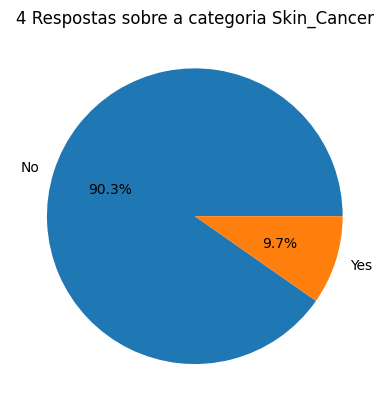

['No' 'Yes']
[278976, 29878]


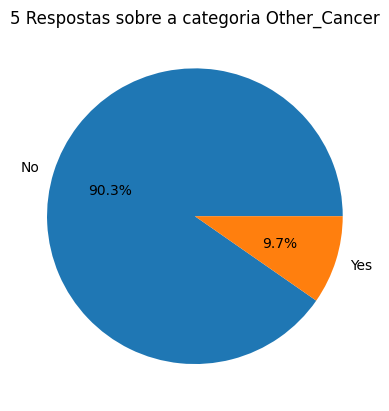

['No' 'Yes']
[246953, 61901]


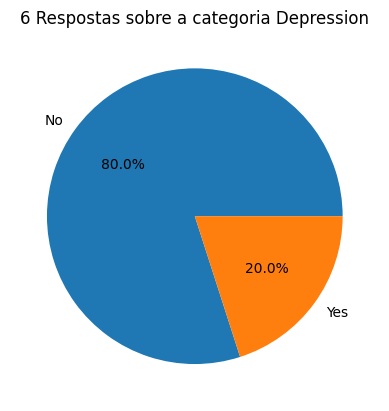

['No' 'No, pre-diabetes or borderline diabetes' 'Yes'
 'Yes, but female told only during pregnancy']
[259141, 6896, 40171, 2646]


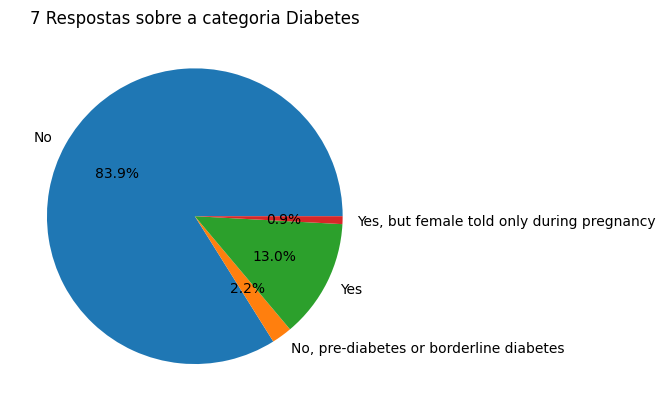

['No' 'Yes']
[207783, 101071]


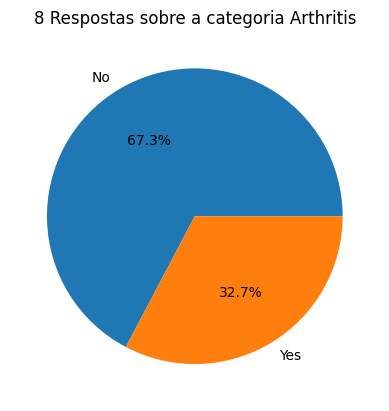

['Female' 'Male']
[160196, 148658]


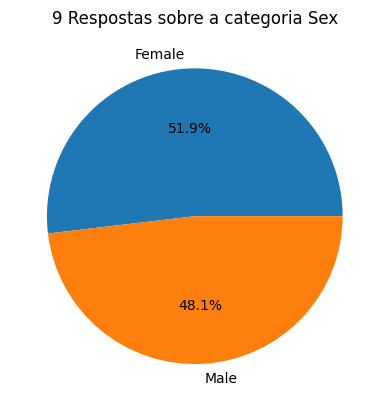

['18-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59' '60-64'
 '65-69' '70-74' '75-79' '80+']
[18681, 15494, 18428, 20606, 21595, 20968, 25097, 28054, 32418, 33434, 31103, 20705, 22271]


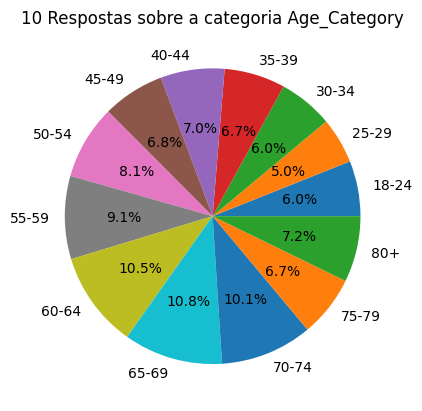

['100.0' '102.0' '103.0' '104.0' '105.0' '106.0' '107.0' '108.0' '110.0'
 '115.0' '117.0' '119.0' '120.0' '122.0' '124.0' '125.0' '127.0' '130.0'
 '132.0' '134.0' '135.0' '137.0' '140.0' '142.0' '143.0' '144.0' '145.0'
 '146.0' '147.0' '148.0' '149.0' '150.0' '151.0' '152.0' '153.0' '154.0'
 '155.0' '156.0' '157.0' '158.0' '159.0' '160.0' '161.0' '162.0' '163.0'
 '164.0' '165.0' '166.0' '167.0' '168.0' '169.0' '170.0' '171.0' '172.0'
 '173.0' '174.0' '175.0' '176.0' '177.0' '178.0' '179.0' '180.0' '181.0'
 '182.0' '183.0' '184.0' '185.0' '186.0' '187.0' '188.0' '189.0' '190.0'
 '191.0' '193.0' '195.0' '196.0' '197.0' '198.0' '200.0' '201.0' '203.0'
 '205.0' '206.0' '208.0' '211.0' '213.0' '216.0' '218.0' '221.0' '224.0'
 '226.0' '229.0' '234.0' '241.0' '91.0' '94.0' '96.0' '97.0' '99.0']
[2, 3, 1, 5, 25, 3, 4, 1, 1, 1, 2, 2, 4, 59, 15, 3, 17, 23, 16, 1, 79, 56, 113, 263, 4, 5, 528, 2, 994, 5, 13, 2918, 20, 9250, 28, 18, 9897, 40, 19377, 33, 20, 20829, 22, 43, 25804, 39, 23551, 24, 39, 

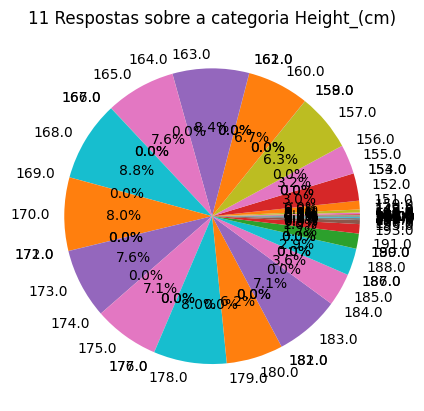

['100.0' '100.24' '100.7' '101.0' '101.15' '101.6' '102.0' '102.06'
 '102.51' '102.97' '103.0' '103.42' '103.87' '104.0' '104.33' '104.78'
 '105.0' '105.23' '105.69' '106.0' '106.14' '106.59' '107.05' '107.5'
 '107.95' '108.41' '108.86' '109.0' '109.32' '109.77' '110.0' '110.22'
 '110.68' '111.13' '111.58' '112.0' '112.04' '112.49' '112.94' '113.0'
 '113.4' '113.85' '114.31' '114.76' '115.0' '115.21' '115.67' '116.0'
 '116.12' '116.57' '117.0' '117.03' '117.48' '117.93' '118.0' '118.39'
 '118.84' '119.0' '119.29' '119.75' '120.0' '120.2' '120.66' '121.11'
 '121.56' '122.02' '122.47' '122.92' '123.38' '123.83' '124.28' '124.74'
 '125.19' '125.65' '126.0' '126.1' '126.55' '127.0' '127.01' '127.46'
 '127.91' '128.37' '128.82' '129.27' '129.73' '130.0' '130.18' '130.63'
 '131.09' '131.54' '132.0' '132.45' '132.9' '133.36' '133.81' '134.0'
 '134.26' '134.72' '135.0' '135.17' '135.62' '136.0' '136.08' '136.53'
 '136.98' '137.44' '137.89' '138.35' '138.8' '139.25' '139.71' '140.0'
 '140.16' '

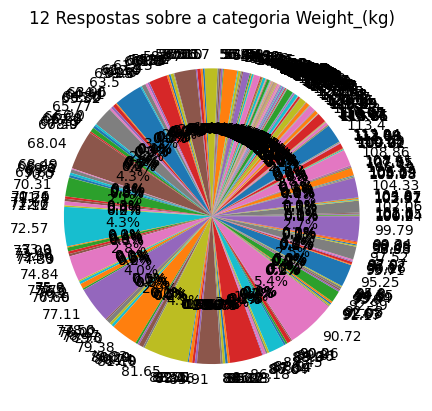

['12.02' '12.05' '12.11' ... '98.44' '99.17' '99.33']
[1, 1, 1, 1, 4, 1, 1, 2, 1, 1, 2, 3, 1, 1, 1, 1, 1, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 3, 1, 1, 1, 4, 4, 1, 2, 1, 2, 6, 4, 1, 4, 1, 1, 2, 1, 2, 4, 2, 2, 2, 1, 1, 3, 2, 2, 5, 6, 3, 3, 2, 1, 1, 2, 6, 4, 1, 2, 2, 3, 2, 3, 3, 5, 1, 1, 3, 1, 7, 5, 2, 1, 3, 1, 2, 4, 6, 1, 2, 9, 1, 6, 2, 3, 10, 5, 1, 2, 5, 8, 4, 1, 4, 1, 1, 7, 1, 2, 8, 6, 1, 2, 1, 3, 4, 4, 5, 8, 7, 2, 6, 3, 7, 2, 1, 2, 3, 9, 2, 9, 6, 5, 17, 4, 4, 26, 1, 3, 1, 4, 13, 5, 1, 11, 16, 12, 2, 2, 2, 1, 11, 3, 2, 15, 12, 1, 9, 6, 6, 6, 2, 13, 6, 6, 48, 5, 4, 1, 1, 2, 3, 16, 10, 28, 3, 5, 9, 25, 1, 3, 2, 1, 1, 3, 4, 4, 5, 20, 36, 9, 7, 8, 23, 1, 7, 5, 2, 2, 21, 14, 4, 53, 9, 1, 1, 11, 1, 4, 48, 15, 8, 14, 8, 8, 13, 36, 2, 10, 5, 5, 6, 10, 5, 3, 68, 8, 19, 13, 37, 1, 12, 5, 6, 2, 2, 2, 12, 1, 4, 16, 28, 80, 10, 25, 18, 2, 59, 73, 2, 11, 7, 1, 2, 20, 33, 4, 2, 19, 1, 67, 1, 5, 66, 2, 78, 39, 17, 25, 1, 26, 1, 10, 16, 39, 10, 58, 21, 9, 1, 20, 1, 10, 112, 76, 11, 131, 16, 9, 19

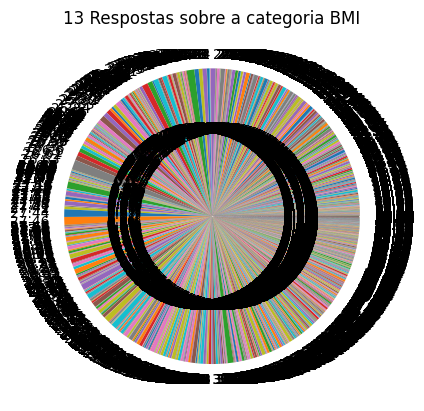

['No' 'Yes']
[183590, 125264]


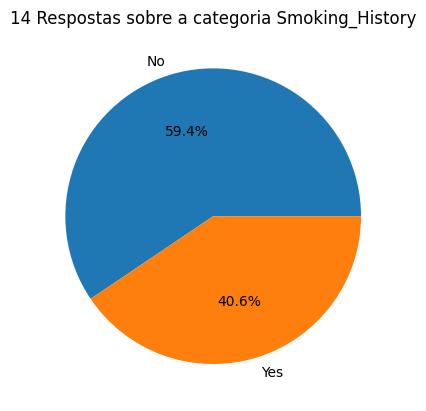

['0.0' '1.0' '10.0' '11.0' '12.0' '13.0' '14.0' '15.0' '16.0' '17.0'
 '18.0' '19.0' '2.0' '20.0' '21.0' '22.0' '23.0' '24.0' '25.0' '26.0'
 '27.0' '28.0' '29.0' '3.0' '30.0' '4.0' '5.0' '6.0' '7.0' '8.0' '9.0']
[140262, 24983, 7881, 41, 8825, 76, 486, 6178, 3602, 78, 196, 11, 19740, 9372, 197, 152, 65, 1253, 2670, 126, 205, 5935, 309, 11479, 11976, 23367, 9622, 3518, 2572, 13438, 239]


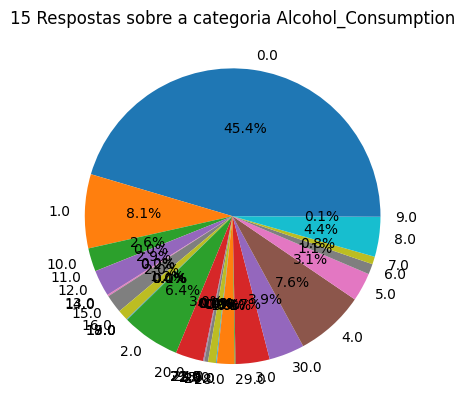

['0.0' '1.0' '10.0' '100.0' '104.0' '108.0' '11.0' '112.0' '116.0' '12.0'
 '120.0' '13.0' '14.0' '15.0' '16.0' '17.0' '18.0' '19.0' '2.0' '20.0'
 '21.0' '22.0' '23.0' '24.0' '25.0' '26.0' '27.0' '28.0' '29.0' '3.0'
 '30.0' '31.0' '32.0' '33.0' '34.0' '35.0' '36.0' '37.0' '38.0' '39.0'
 '4.0' '40.0' '41.0' '42.0' '44.0' '45.0' '48.0' '5.0' '50.0' '52.0'
 '54.0' '55.0' '56.0' '6.0' '60.0' '62.0' '63.0' '64.0' '65.0' '68.0'
 '7.0' '70.0' '72.0' '75.0' '76.0' '8.0' '80.0' '84.0' '85.0' '88.0' '9.0'
 '90.0' '92.0' '96.0' '97.0' '98.0' '99.0']
[8333, 3350, 4471, 14, 1, 1, 21, 3, 1, 30259, 3113, 36, 235, 4066, 17444, 54, 86, 7, 5792, 17476, 63, 52, 19, 2409, 1137, 33, 47, 3379, 27, 4643, 90273, 43, 322, 13, 2, 41, 70, 1, 2, 2, 13687, 2003, 1, 2, 24, 115, 145, 5219, 76, 3, 1, 5, 108, 1686, 48127, 1, 1, 4, 9, 4, 965, 5, 12, 7, 4, 22279, 89, 22, 1, 9, 102, 16567, 3, 26, 1, 1, 199]


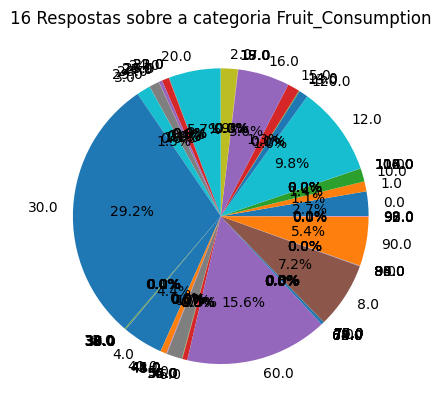

['0.0' '1.0' '10.0' '100.0' '104.0' '11.0' '112.0' '12.0' '120.0' '124.0'
 '128.0' '13.0' '14.0' '15.0' '16.0' '17.0' '18.0' '19.0' '2.0' '20.0'
 '21.0' '22.0' '23.0' '24.0' '25.0' '26.0' '27.0' '28.0' '29.0' '3.0'
 '30.0' '31.0' '32.0' '33.0' '34.0' '35.0' '36.0' '37.0' '39.0' '4.0'
 '40.0' '44.0' '45.0' '48.0' '5.0' '50.0' '52.0' '53.0' '55.0' '56.0'
 '6.0' '60.0' '61.0' '64.0' '65.0' '68.0' '7.0' '70.0' '75.0' '76.0'
 '77.0' '8.0' '80.0' '84.0' '85.0' '88.0' '9.0' '90.0' '92.0' '93.0'
 '95.0' '96.0' '97.0' '98.0' '99.0']
[21389, 8511, 6254, 9, 2, 31, 4, 41979, 615, 2, 1, 54, 375, 7002, 23338, 90, 170, 11, 11350, 21288, 129, 104, 59, 2788, 2204, 60, 71, 2678, 42, 6461, 51162, 26, 106, 7, 1, 15, 27, 1, 2, 37709, 955, 4, 46, 43, 6267, 34, 5, 1, 2, 55, 2295, 8796, 1, 1, 4, 1, 1484, 2, 7, 3, 1, 40329, 73, 7, 1, 6, 148, 1944, 2, 1, 2, 37, 1, 1, 168]


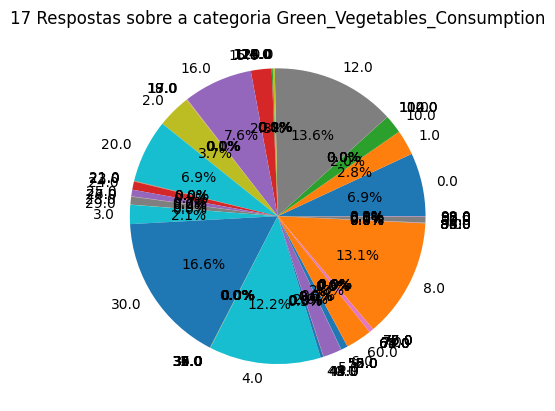

['0.0' '1.0' '10.0' '100.0' '11.0' '112.0' '12.0' '120.0' '124.0' '128.0'
 '13.0' '14.0' '15.0' '16.0' '17.0' '18.0' '19.0' '2.0' '20.0' '21.0'
 '22.0' '23.0' '24.0' '25.0' '26.0' '27.0' '28.0' '29.0' '3.0' '30.0'
 '31.0' '32.0' '33.0' '34.0' '35.0' '36.0' '37.0' '4.0' '40.0' '41.0'
 '42.0' '44.0' '45.0' '46.0' '48.0' '49.0' '5.0' '50.0' '52.0' '56.0'
 '6.0' '60.0' '64.0' '68.0' '7.0' '72.0' '76.0' '8.0' '80.0' '84.0' '88.0'
 '9.0' '90.0' '92.0' '95.0' '96.0' '97.0' '98.0' '99.0']
[44233, 29876, 7549, 2, 40, 1, 21940, 205, 1, 2, 50, 262, 4559, 8038, 49, 96, 5, 36095, 6908, 39, 30, 11, 579, 522, 12, 19, 555, 16, 15347, 8434, 13, 45, 10, 1, 4, 15, 1, 67833, 234, 1, 2, 2, 5, 1, 16, 1, 10121, 19, 1, 14, 3011, 1082, 2, 3, 1884, 1, 1, 38366, 21, 3, 3, 145, 461, 3, 1, 8, 1, 1, 43]


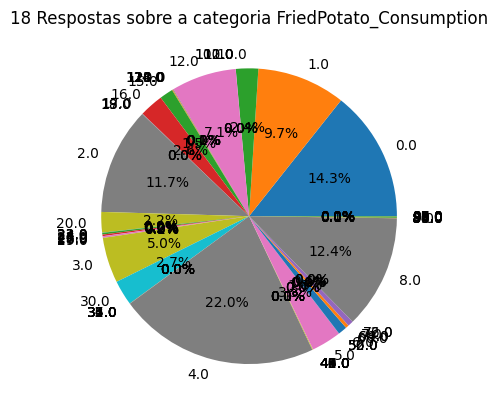

[['Poor' 'Very Good' 'Very Good' ... 'Very Good' 'Very Good' 'Excellent']
 ['Within the past 2 years' 'Within the past year' 'Within the past year'
  ... '5 or more years ago' 'Within the past year' 'Within the past year']
 ['No' 'No' 'Yes' ... 'Yes' 'Yes' 'Yes']
 ...
 ['30.0' '30.0' '12.0' ... '40.0' '30.0' '5.0']
 ['16.0' '0.0' '3.0' ... '8.0' '12.0' '12.0']
 ['12.0' '4.0' '16.0' ... '4.0' '0.0' '1.0']]


In [ ]:
										#-----------------------------#
										#    2. DATA UNDERSTANDING    #
										#-----------------------------#

import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.2.1.

with open('dataset.csv', mode ='r')as file:
	csvFile = csv.reader(file)
	categorias = next(csvFile)

dadosC = pd.read_csv("dataset.csv")
datasetC = [] # dataset por coluna

for i in categorias:
    datasetC.append(dadosC[i].tolist())

datasetC = np.array(datasetC)

# 2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.2.2.2.3.

# exemplos do dataset
'''
for i in range(len(categorias)):
    print("Categoria "+str(categorias[i])+":")
    print(datasetC[i,0:5],end="\n\n")
'''

# tipos de diferentes respostas a cada categoria
for i in range(len(categorias)):
    print("Tipos de respostas para a categoria "+str(categorias[i])+":")
    print(np.unique(datasetC[i]),end="\n\n")



# graficos para respostas
count = 0
for i in datasetC:
	unicos = np.unique(i)
	valores = [np.count_nonzero(i==x) for x in unicos]
    
	print(unicos)
	print(valores)

	plt.title(str(count)+" Respostas sobre a categoria "+str(categorias[count]))
	plt.pie(valores,labels=unicos,autopct='%1.1f%%')
	plt.show()
	count+=1 


# pessoas que dizem que n fazem exercicio -> +% na parte de doencas
'''
indices = []
for i in range(len(datasetC[2])):
    #3 4 5 6 7 8
    if datasetC[2][i] == "No":
        indices.append(i)

for i in range(3,9):
	unicos = np.unique(datasetC[i])
	valores = [str(datasetC[i][j]) for j in indices]
	valores = np.array(valores)
	valores2 = [np.count_nonzero(valores==x) for x in unicos]
    
	plt.title("Respostas para pessoas que nao fazem exercicio para a categoria "+str(categorias[i]))
	plt.pie(valores2,labels=unicos,autopct='%1.1f%%')
	plt.show()
'''


# ver que respostas deram as pessoas que tem problemas cardiacos
'''
indices = []
for i in range(len(datasetC[3])):
    if datasetC[3][i] == "Yes":
        indices.append(i)

for i in range(len(categorias)):
	unicos = np.unique(datasetC[i])
	valores = [str(datasetC[i][j]) for j in indices]
	valores = np.array(valores)
	valores2 = [np.count_nonzero(valores==x) for x in unicos]
    
	plt.title("Respostas para pessoas que têm doenças cardiacas para a categoria "+str(categorias[i]))
	plt.pie(valores2,labels=unicos,autopct='%1.1f%%')
	plt.show()
'''

# 2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.2.4.

# falar da inconsistencia das batatas fritas / alcool / fruta / vegetais
# vou usar quantas vezes por mes come/bete a categoria

# mostrar que nao tem valores em falta
'''
for i in datasetC:
    print(len(i))
print(len(datasetC.T))
'''

### 3. Data Preparation

- 3.1. Select data - Determine which data sets will be used and document reasons for inclusion/exclusion.
- 3.2. Clean data - Often this is the lengthiest task. Without it, you’ll likely fall victim to garbage-in, garbage-out. A common practice during this task is to correct, impute, or remove erroneous values.
- 3.3. Construct data - Derive new attributes that will be helpful. For example, derive someone’s body mass index from height and weight fields.
- 3.4. Integrate data - Create new data sets by combining data from multiple sources.
- 3.5. Format data - Re-format data as necessary. For example, you might convert string values that store numbers to numeric values so that you can perform mathematical operations.

Esta parte vai ser para a parte de alterar o dataset que o stor disse, depois temos de incluir estes topicos talvez

###### - Randomly remove 10% and 20% of the values of the features the dataset and explore two different strategies to handle missing values;
###### - Experiment with data normalization, data discretization, and data reduction. Apply these steps to the original, unchanged, dataset.

Nones testes[0] 55932
len() testes[0] 308854
Nones testes2[0] 0
len() testes2[0] 308854
['150.0', '165.0', '163.0', '180.0', '191.0', '183.0', '175.0', '165.0', '163.0', '163.0', '160.0', '175.0', '168.0', '178.0', '152.0', '163.0', '183.0', '168.0', '178.0', '163.0']
[150.0, 165.0, 163.0, 180.0, 191.0, 183.0, 175.0, 165.0, 163.0, 163.0, 160.0, 175.0, 168.0, 178.0, 152.0, 163.0, 183.0, 168.0, 178.0, 163.0]
['150-160', '161-170', '161-170', '171-180', '191-200', '181-190', '171-180', '161-170', '161-170', '161-170', '150-160', '171-180', '161-170', '171-180', '150-160', '161-170', '181-190', '161-170', '171-180', '161-170', '150-160', '171-180', '171-180', '161-170', '150-160', '150-160', '150-160', '150-160', '191-200', '171-180', '150-160', '161-170', '181-190', '150-160', '181-190', '161-170', '161-170', '161-170', '161-170', '161-170', '150-160', '171-180', '161-170', '171-180', '161-170', '171-180', '161-170', '161-170', '161-170', '150-160']
308854
['150-160' '161-170' '171-180' '

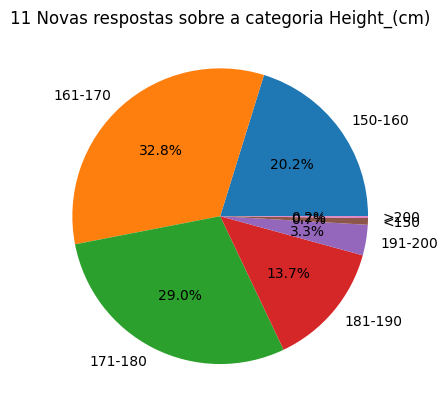

['101-120' '121-140' '40-60' '61-80' '81-100' '<40' '>140']
[37884, 13383, 34838, 114606, 103098, 290, 4755]


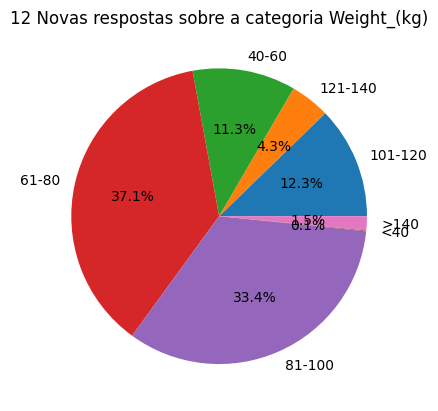

['gorda' 'magra' 'normal' 'obesa']
[25106, 25293, 254425, 4030]


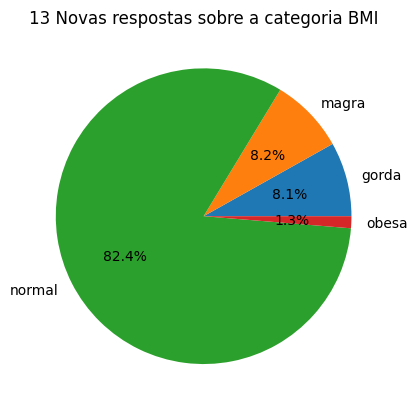

['bastante' 'medio' 'muito' 'nada' 'pouco']
[22888, 46136, 19999, 140262, 79569]


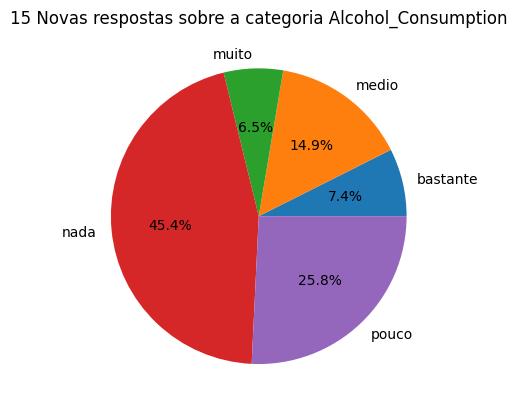

['bastante' 'medio' 'muito' 'muito pouco' 'nada' 'pouco']
[20098, 115062, 51106, 57621, 8333, 56634]


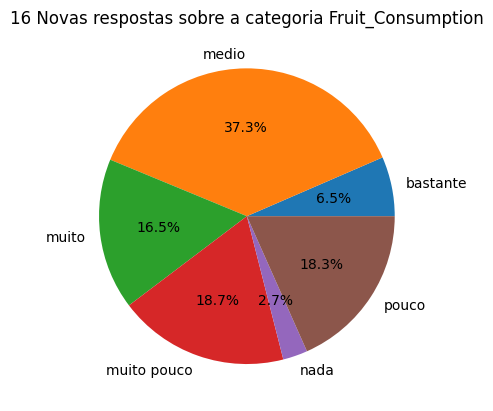

[' muito' 'medio' 'muito pouco' 'nada' 'pouco']
[13022, 80856, 114406, 21389, 79181]


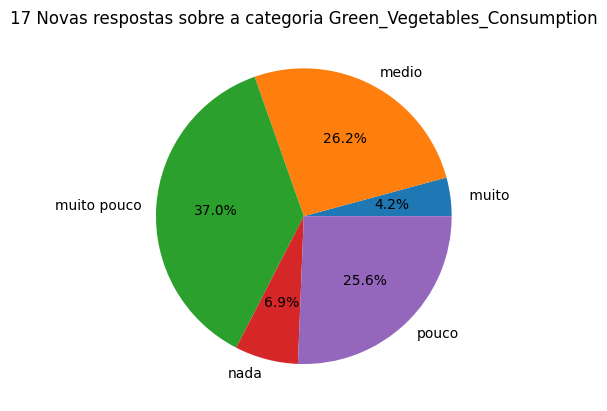

['bastante' 'medio' 'muito' 'nada' 'pouco']
[32414, 53382, 29674, 44233, 149151]


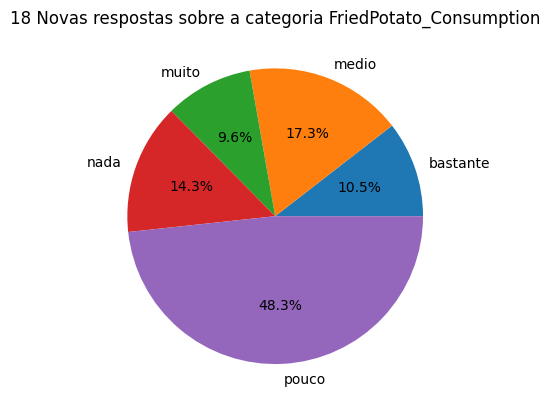

[array([3, 4, 4, ..., 4, 4, 0]), array([2, 4, 4, ..., 0, 4, 4]), array([0, 0, 1, ..., 1, 1, 1]), array([0, 1, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 1, 0, 0]), array([0, 2, 2, ..., 3, 0, 0]), array([1, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 0]), array([10, 10,  8, ...,  2,  9,  5]), array([150., 165., 163., ..., 157., 183., 160.]), array([32.66, 77.11, 88.45, ..., 61.23, 79.38, 81.19]), array([14.54, 28.29, 33.47, ..., 24.69, 23.73, 31.71]), array([1, 0, 0, ..., 1, 0, 0]), array([0., 0., 4., ..., 4., 3., 1.]), array([30., 30., 12., ..., 40., 30.,  5.]), array([16.,  0.,  3., ...,  8., 12., 12.]), array([12.,  4., 16., ...,  4.,  0.,  1.])]
19


In [ ]:
										#-----------------------------#
										#     3. DATA PREPARATION     #
										#-----------------------------#

from collections import Counter
from sklearn.preprocessing import LabelEncoder

# REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS
# REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS
# REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS REMOVER DADOS

# remove os dados do dataset dado com a percentagem dada
def remover_dados(percentagem,dataset):
    
	tamanho = 0
	for i in range(len(dataset)): # calcula tamanho do dataset
		tamanho += len(dataset[i])

	for i in range(int(tamanho*percentagem)):
		dataset[random.randint(0,len(dataset)-1)][random.randint(0,len(dataset[0])-1)] = None # elemento random mete para None

	return dataset

# testes ---------------------
copia = datasetC.copy()

testes = remover_dados(0.2,copia) # dataset com None
ok = 0
for i in testes[0]:
	if i == "None":
		ok+=1
print("Nones testes[0] "+str(ok))
print("len() testes[0] "+str(len(testes[0])))
# ---------------------------------------------------------------

# Metodo extra - apagar os dados




# METODO 1 - Vicente, substituir pelo valor mais frequente

# pega no dataset com Nones e substitui-os pelo valor mais frequente da categoria
def mais_freq(dataset):
	dataset = dataset.tolist() # é mais rapido se for lista normal em vez de np.array (nao sei porque)
	maxx = []
	for i in range(len(dataset)): # VER O BMI
		conta = Counter(dataset[i])
		del conta["None"]
		#print(conta.most_common(1))
		maxx.append(conta.most_common(1))

	#print(maxx)
	#print(maxx[0])
	#print(maxx[0][0][0])

	for i in range(len(dataset)):
		for j in range(len(dataset[i])):
			if dataset[i][j] == "None":
				dataset[i][j] = maxx[i][0][0]
	
	return dataset

testes2 = mais_freq(testes) # dataset com None substituido por mais frequente
ok2 = 0
for i in testes2[0]:
	if i == "None":
		ok2+=1
print("Nones testes2[0] "+str(ok2))
print("len() testes2[0] "+str(len(testes2[0])))


# METODO 2 - jonnas






# DATA DISCRETIZATION - Vicente

# as comidas e bebidas para - nada muito_pouco pouco medio muito bastante
# altura - >100, 100-110, 111-120, 121-130, 131-140, 141-150, 151-160, 161-170, 171-180, 181-190, 191-200, <200
# BMI -> muito magro, magro normal, gordo, obeso, obesidade morbida
# peso -> data['bins'] = pd.cut(data['values'], bins=5, labels=['Low', 'Medium', 'High'])

def data_discretization(dataset):

	print(dataset[11][0:20])
	for i in [11,12,13,15,16,17,18]:
		dataset[i] = list(map(float, dataset[i]))
	print(dataset[11][0:20])

	#ALTURA
	for i in range(len(dataset[11])):
		if dataset[11][i] < 150: # +1.5m
			dataset[11][i] = "<150"
		elif dataset[11][i] >= 150 and dataset[11][i] <=160: # entre 1.5 e 1.6 m
			dataset[11][i] = "150-160"
		elif dataset[11][i] > 160 and dataset[11][i] <=170: # entre 1.6 e 1.7 m
			dataset[11][i] = "161-170"
		elif dataset[11][i] > 170 and dataset[11][i] <=180: # entre 1.7 e 1.8 m
			dataset[11][i] = "171-180"
		elif dataset[11][i] > 180 and dataset[11][i] <=190: # entre 1.8 e 1.9 m
			dataset[11][i] = "181-190"
		elif dataset[11][i] > 190 and dataset[11][i] <=200: # entre 1.9 e 2.0 m
			dataset[11][i] = "191-200"
		else: # +2.0m
			dataset[11][i] = ">200"
	
	#PESO
	for i in range(len(dataset[12])):
		if dataset[12][i] < 40: # -40kg
			dataset[12][i] = "<40"
		elif dataset[12][i] >= 40 and dataset[12][i] <=60: # entre 40 a 60 kg
			dataset[12][i] = "40-60"
		elif dataset[12][i] > 60 and dataset[12][i] <=80: # entre 60 a 80 kg
			dataset[12][i] = "61-80"
		elif dataset[12][i] > 80 and dataset[12][i] <=100: # entre 80 a 100 kg
			dataset[12][i] = "81-100"
		elif dataset[12][i] > 100 and dataset[12][i] <=120: # entre 100 a 120 kg
			dataset[12][i] = "101-120"
		elif dataset[12][i] > 120 and dataset[12][i] <=140: # entre 120 a 140 kg
			dataset[12][i] = "121-140"
		else: # +140kg
			dataset[12][i] = ">140" 

	#BMI
	for i in range(len(dataset[13])):
		bmi = 10 + (dataset[13][i] / 100) * (50-10) # meter a percentagem do dataset em categorias tabeladas do BMI
		if bmi < 18.5:
			dataset[13][i] = "magra"
		elif bmi >= 18.5 and bmi <= 24.9:
			dataset[13][i] = "normal"
		elif bmi >= 25 and bmi <= 29.9:
			dataset[13][i] = "gorda"
		else:
			dataset[13][i] = "obesa"
		
	#ALCOOL
	for i in range(len(dataset[15])):
		if dataset[15][i] == 0: # 0 - nada
			dataset[15][i] = "nada"
		elif dataset[15][i]>0 and dataset[15][i] <= 4: # 1x por semana - pouco
			dataset[15][i] = "pouco"
		elif dataset[15][i]>4 and dataset[15][i] <=12: #2/3x por semana - medio
			dataset[15][i] = "medio"
		elif dataset[15][i] > 12 and dataset[15][i] <= 20: # 4/5x por semana - muito
			dataset[15][i] = "muito"
		else: # +5x por semana - bastante
			dataset[15][i] = "bastante"

	#FRUTA
	for i in range(len(dataset[16])):
		if dataset[16][i] == 0: # 0 - nada
			dataset[16][i] = "nada"
		elif dataset[16][i] >0 and dataset[16][i] <9: # 1/2x por semana - muito pouco
			dataset[16][i] = "muito pouco"
		elif dataset[16][i] >=9 and dataset[16][i] <17: # 3/4x por semana - pouco
			dataset[16][i] = "pouco"
		elif dataset[16][i] >=17 and dataset[16][i] <31: # 5x por semana a 1x por dia - medio
			dataset[16][i] = "medio"
		elif dataset[16][i] >=31 and dataset[16][i] <61: # 1/2x por dia - muito
			dataset[16][i] = "muito"
		else: # +2x por dia - bastante
			dataset[16][i] = "bastante"

	#VEGETAIS
	for i in range(len(dataset[17])):
		if dataset[17][i] == 0: # 0 nada
			dataset[17][i] = "nada"
		elif dataset[17][i] >0 and dataset[17][i] <9: # 1/2x por semana - muito pouco
			dataset[17][i] ="muito pouco"
		elif dataset[17][i] >=9 and dataset[17][i] <17: # 3/4x por semana - pouco
			dataset[17][i] = "pouco"
		elif dataset[17][i] >=17 and dataset[17][i] <31: # 5x por semana a 1x por dia - medio
			dataset[17][i] = "medio"
		else: # +1x por dia - muito
			dataset[17][i] = " muito"

	#BATATA FRITA
	for i in range(len(dataset[18])):
		if dataset[18][i] == 0: # 0 - nada
			dataset[18][i] = "nada"
		elif dataset[18][i]> 0 and dataset[18][i] <5: #1x por semana - pouco
			dataset[18][i] = "pouco"
		elif dataset[18][i] >=5 and dataset[18][i] <9: # 2x por semana - medio
			dataset[18][i] = "medio"
		elif dataset[18][i] >=9 and dataset[18][i] <13: # 3x por semana - muito
			dataset[18][i] = "muito"
		else: # +3x por semana - bastante
			dataset[18][i] = "bastante"

	return dataset

copia2 = datasetC.copy()
copia2 = copia2.tolist()

#testes3 = data_discretization(testes2) # dataset com Nones, substituidos por mais frequente, com data discretization

testes4 = data_discretization(copia2) # dataset com data discretization
#''' graficos
print(testes4[11][0:50])
print(len(testes4[11]))

testes4 = np.array(testes4)

for i in [11,12,13,15,16,17,18]:
	unicos = np.unique(testes4[i])
	valores = [np.count_nonzero(testes4[i]==x) for x in unicos]
    
	print(unicos)
	print(valores)

	plt.title(str(i)+" Novas respostas sobre a categoria "+str(categorias[i]))
	plt.pie(valores,labels=unicos,autopct='%1.1f%%')
	plt.show()



# DATA REDUCTION - Vicente

#print(dataset_num) dups
#print(len(dataset_num))
#print(len(np.unique(dataset_num,axis=0)))

# fazer modelos pra ver atributos que posso remover (0, 1 e 6 principalmente)


# DATA NORMALIZATION - Jonnas




# meter os dados para numeros

testes4 = np.array(testes4)
dataset_num = []

# meter o datset para numeros para dar com os modelos
for col in datasetC:
    try:
        dataset_num.append(col.astype(float))
    except ValueError:
        le = LabelEncoder()
        encoded_col = le.fit_transform(col)
        dataset_num.append(encoded_col)

print(dataset_num)
print(len(dataset_num))
dataset_num = np.array(dataset_num).T # dataset com as repostas normais como está no csv

### 4. Modeling

- 4.1. Select modeling techniques - os algoritmos que o stor pede no enunciado
- 4.2. Generate test design - dependendo do modelo ter diferentes valores de sets de train, teste e validation
- 4.3. Build model - implementar os modelos
- 4.4. Assess model - interpretar os resultados dos modelos e comprara-los e testalos entre eles para ver qual/quais são os melhores

categorias ['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
[[ 3.  2.  0. ... 30. 16. 12.]
 [ 4.  4.  0. ... 30.  0.  4.]
 [ 4.  4.  1. ... 12.  3. 16.]
 ...
 [ 4.  0.  1. ... 40.  8.  4.]
 [ 4.  4.  1. ... 30. 12.  0.]
 [ 0.  4.  1. ...  5. 12.  1.]]
308854
308774
308854


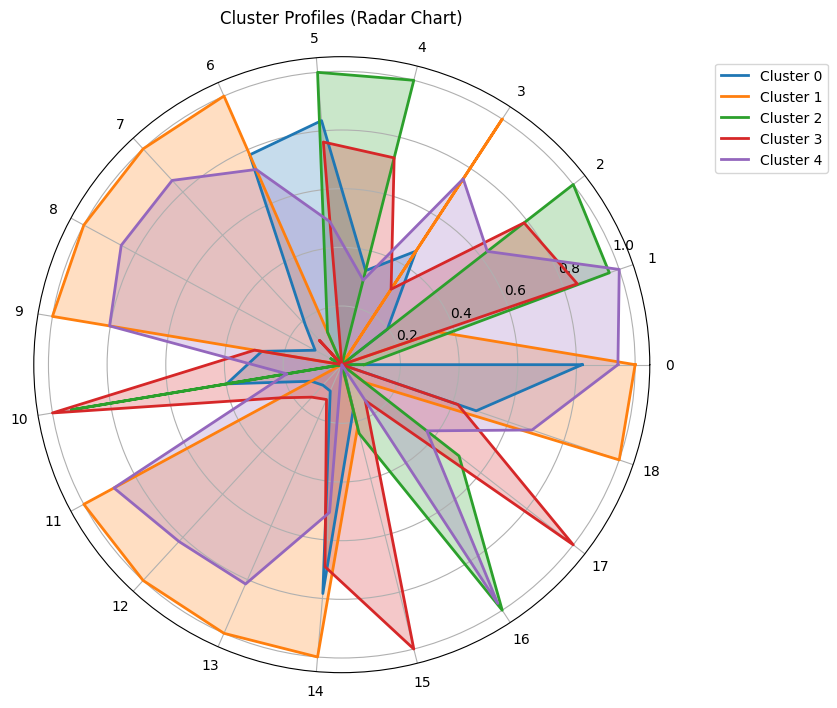

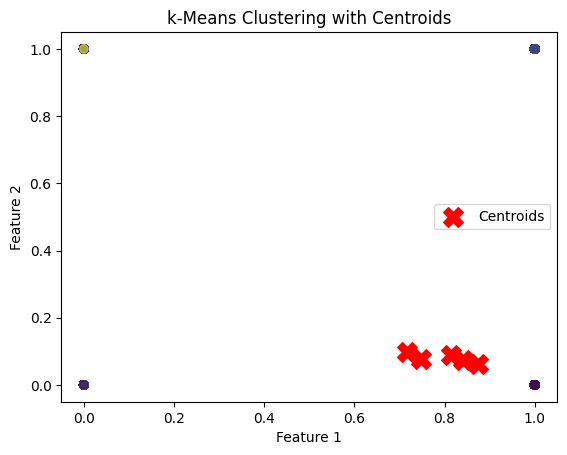

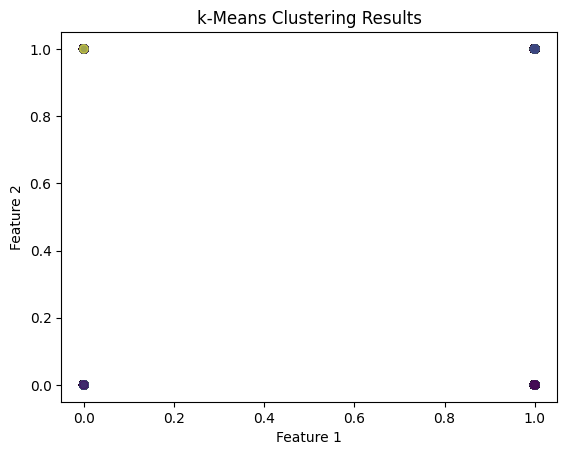

/tmp/ipykernel_67707/2838720063.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=data_with_clusters, palette='viridis')


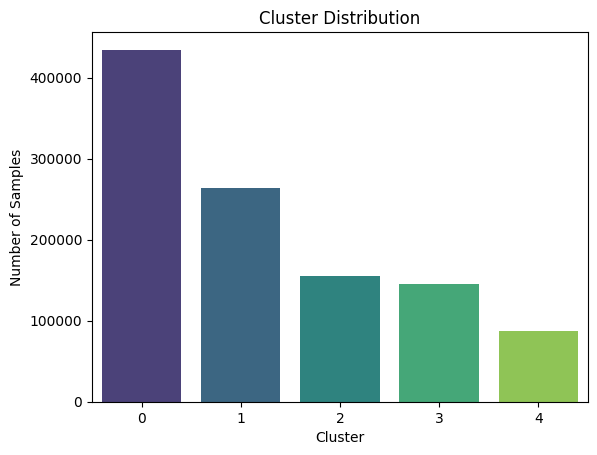

[0 1]
Counter({0: 283883, 1: 24971})


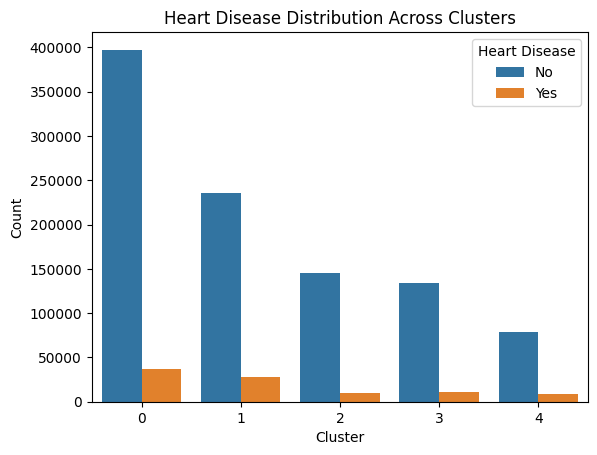

In [7]:
										#-----------------------------#
										#         4. Modeling         #
										#-----------------------------#

# UNSUPERVISED LEARNING - Vicente

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns


print("categorias "+str(categorias))


print(dataset_num)
print(len(dataset_num))
print(len(np.unique(dataset_num,axis=0)))

#unicos = np.unique(dataset_num)
#valores = [np.count_nonzero(dataset_num==x) for x in unicos]
#print(unicos)
#print(valores)


kmeans = KMeans(n_clusters=5)
kmeans.fit(dataset_num)
cluster_labels = kmeans.labels_

print(len(cluster_labels))

# Step 3: Analyze clusters
# Add cluster labels to a DataFrame for analysis
data_with_clusters = pd.DataFrame(dataset_num)
data_with_clusters['Cluster'] = cluster_labels

#print(dataset_num)
#print(data_with_clusters)

# Display basic cluster statistics
#cluster_summary = data_with_clusters.groupby('Cluster').mean()
#print("Cluster Summary:")
#print(cluster_summary)

# Step 4: Visualize results
# Plot first two features for visualization (or use PCA for dimensionality reduction)



from math import pi

# Compute mean values for each feature in each cluster
cluster_profiles = data_with_clusters.groupby('Cluster').mean()

# Radar chart requires normalizing the data
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

# Create radar chart
categories = cluster_profiles_normalized.columns
num_clusters = cluster_profiles_normalized.shape[0]
angles = np.linspace(0, 2 * pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
for i in range(num_clusters):
    values = cluster_profiles_normalized.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, label=f"Cluster {i}", linewidth=2)
    ax.fill(angles, values, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title("Cluster Profiles (Radar Chart)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()


# Extract cluster centroids
centroids = kmeans.cluster_centers_

# Scatter plot with centroids
plt.scatter(dataset_num[:, 2], dataset_num[:, 3], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 2], centroids[:, 3], c='red', marker='X', s=200, label='Centroids')
plt.title("k-Means Clustering with Centroids")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


plt.scatter(dataset_num[:, 2], dataset_num[:, 3], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.title("k-Means Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


sns.countplot(x='Cluster', data=data_with_clusters, palette='viridis')
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Samples")
plt.show()


#print(data_with_clusters['Cluster'])


# Assuming 'Heart_Disease' is the third column (index 2) in datasetC.T
heart_disease_column = testes4.T[:, 3]  # Extract the column
# Convert 'Yes' to 1 and 'No' to 0
heart_disease_column_numeric = np.where(heart_disease_column == 'Yes', 1, 0)
#print(len(data_with_clusters.T))  # Should match len(datasetC.T)
#print(len(heart_disease_column_numeric))  # Should match len(datasetC.T)
# Add heart disease column to the DataFrame with clusters
data_with_clusters['Heart Disease'] = heart_disease_column_numeric

print(np.unique(data_with_clusters['Heart Disease']))

print(Counter(data_with_clusters['Heart Disease']))
#print(len(data_with_clusters))  # Should match len(datasetC.T)
#print(data_with_clusters[0])
#print(len(heart_disease_column_numeric))  # Should match len(datasetC.T)


# Create a count plot to show heart disease distribution across clusters
sns.countplot(x='Cluster', hue='Heart Disease', data=data_with_clusters)
plt.title("Heart Disease Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Heart Disease", labels=["No", "Yes"])
plt.show()



### 5. Evaluation

- 5.1. Evaluate results - ver que modelos devemos usar e quais melhor correspondem com o business criteria
- 5.2. Review process - fazer uma revisão critica ao trabalho feito
- 5.3. Determine next steps - determnar se esta bom para o deploymente, se é preciso melhorar um pouco mais ou expandir o projeto // ns bem como fazer isto neste trabalho

In [8]:
										#-----------------------------#
										#        5. Evaluation        #
										#-----------------------------#

